# Model initialization and weights
You can download the weights from here: https://drive.google.com/file/d/1lmKaJmXEFfcDuQqh2k6sK5JmDDxmQGzE/view?usp=drive_link

The Planck dataset can be downloaded from here: https://drive.google.com/drive/folders/1hE8Mf49Jlj5Jg44M1Om09-mKsNZKGGk3?usp=drive_link

For the training and validation datasets, you can easily create it by running the ```data_generator.py``` file from the root of the repository. That is, run the following in the terminal: ```python src/data_generator.py```

In [1]:
from model import UNet
from dataset import ImagesAndMasksDataset
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

num_classes = 181
path = "../model_saves/unet_256_256_1_10_0_0_0_3.5rects_10000_trial12_33epoch_0.00023451543556706085.pt"  # path where the downloaded model weights are stored 
unet = UNet(num_classes=num_classes, apply_batch_norm=False).to("cpu")

unet.load_state_dict(torch.load(path, map_location=torch.device("cpu"))["model_state_dict"])
unet.eval()

UNet(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (up_convs): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  )
  (double_convs): ModuleList(
    (0): DoubleConv(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): DoubleConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): DoubleConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [2]:
train_image_dir = '../data/Rects/256_256_1_10_0_0_0_3.5rects_10000_output/train/imgs/'   
train_mask_dir = '../data/Rects/256_256_1_10_0_0_0_3.5rects_10000_output/train/masks/'
val_image_dir = '../data/Rects/256_256_1_10_0_0_0_3.5rects_10000_output/val/imgs/'
val_mask_dir = '../data/Rects/256_256_1_10_0_0_0_3.5rects_10000_output/val/masks/'
planck_image_dir = '../data/PlanckData/images'   # these are the actual images 
planck_mask_dir = '../data/PlanckData/masks'   # these are the binary masks obtained from the images 
planck_theta_dir = '../data/PlanckData/thetas'  # these are the correct angles 

batch_size = 16 

train_dataset = ImagesAndMasksDataset(train_image_dir, train_mask_dir)
val_dataset = ImagesAndMasksDataset(val_image_dir, val_mask_dir)
planck_images_dataset = ImagesAndMasksDataset(planck_image_dir, planck_theta_dir)
planck_masks_dataset = ImagesAndMasksDataset(planck_mask_dir, planck_theta_dir)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
planck_images_dataloader = DataLoader(dataset=planck_images_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
planck_masks_dataloader = DataLoader(dataset=planck_masks_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

# Inference on validation data

In [3]:
def get_unet_masks(unet: UNet, images: torch.Tensor) -> torch.Tensor:  # TODO: move this to utils.py
    unet_raw_masks = unet(images)  # images are of shape [N, C, H, W]
    unet_masks = torch.argmax(unet_raw_masks, dim=1)
    return unet_masks

In [4]:
size = 30
images, masks = next(iter(val_dataloader))
print("IMG SHAPE ", images.shape, np.unique(images))
print("MASK SHAPE ", masks.shape)

unet_masks = get_unet_masks(unet, images)

IMG SHAPE  torch.Size([16, 1, 256, 256]) [0. 1.]
MASK SHAPE  torch.Size([16, 256, 256])


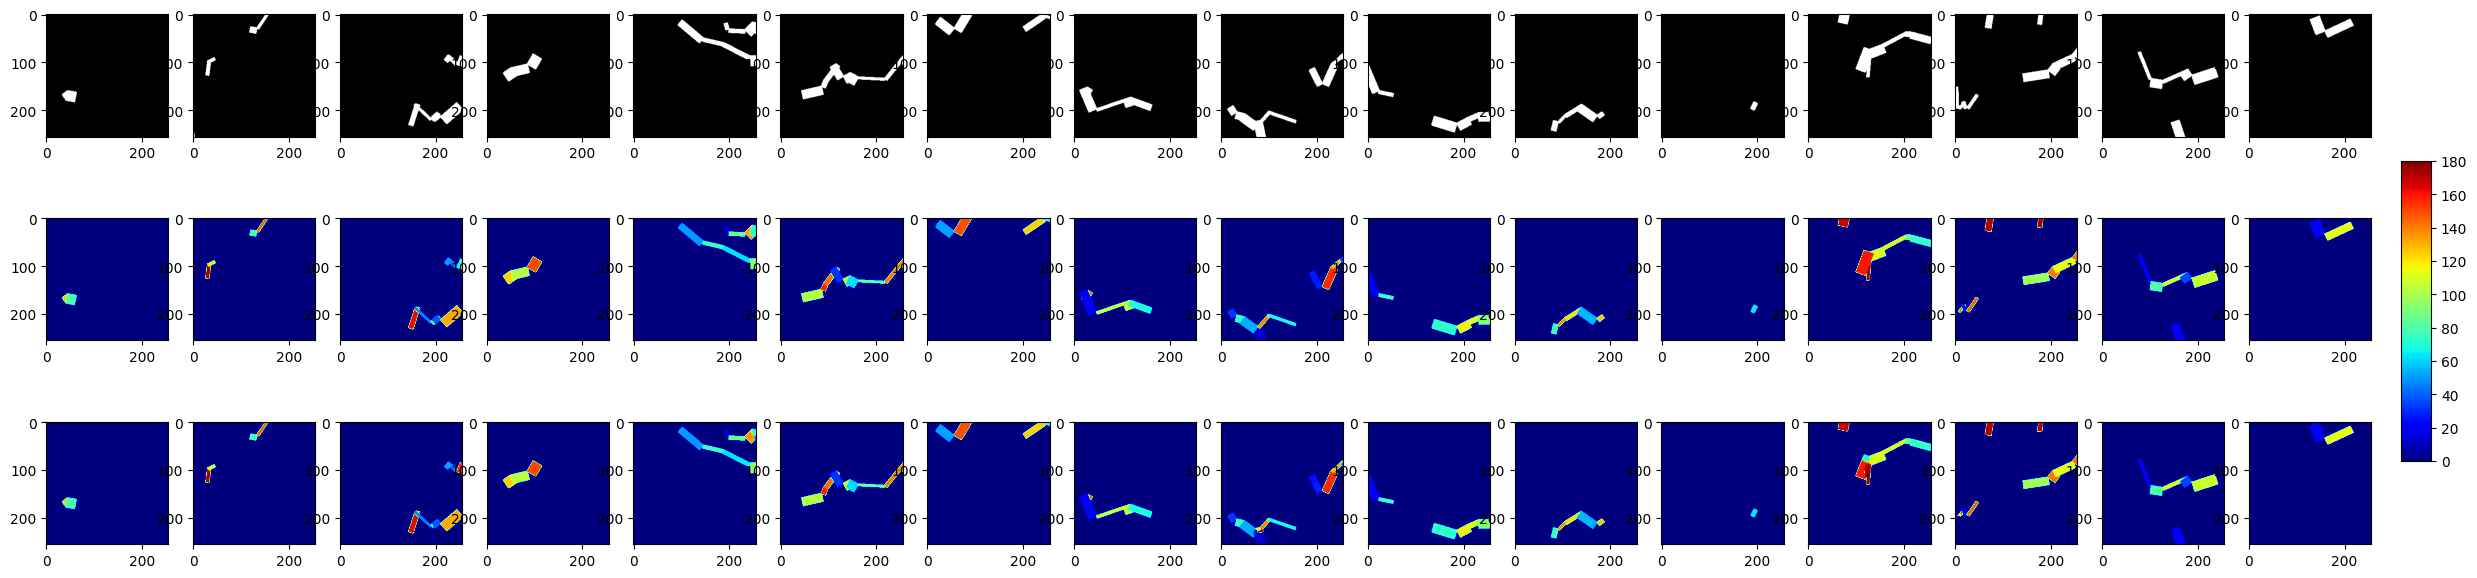

In [12]:
fig, axs = plt.subplots(3, batch_size, figsize=(size,size/4))
for i in range(batch_size):
    axs[0, i].imshow(images[i,0,:,:], cmap="gray", vmin=0, vmax=1)     # first row are the input images
    im = axs[1, i].imshow(masks[i,:,:], cmap="jet", vmin=0, vmax=180)  # second row are the true masks 
    axs[2, i].imshow(unet_masks[i,:,:], cmap="jet", vmin=0, vmax=180)  # third row are the predicted masks
cbax = fig.add_axes([0.91, 0.2529, 0.01, 0.4])
fig.colorbar(im, cax=cbax)

# Inference on real data
On real data, images need to be preprocessed first to get good performance. 
Ideally, we should preprocess the images in a way s.t. the final resulting images are binary images filled with 0 or 1 pixel values.
However, if the resulting images are close enough to being binary (image mean $\approx$ 1), then that works too.
The reason why this is required is because the training data consists of binary images.

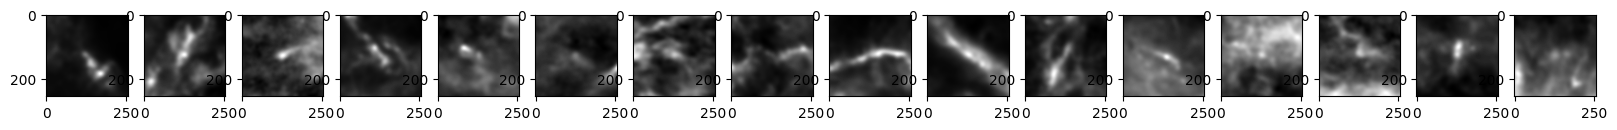

In [13]:
size = 20

images_planck, masks_planck = next(iter(planck_images_dataloader))
fig, axs = plt.subplots(1, batch_size, figsize=(size,size))
for i in range(batch_size):
    axs[i].imshow(images_planck[i,0,:,:], cmap='gray', vmin=0, vmax=1)

In [14]:
images_planck_np = (images_planck*255).detach().cpu().numpy().astype(np.float32)

255.0 1.5588068962097168
217.5 0.8707666397094727 0.0


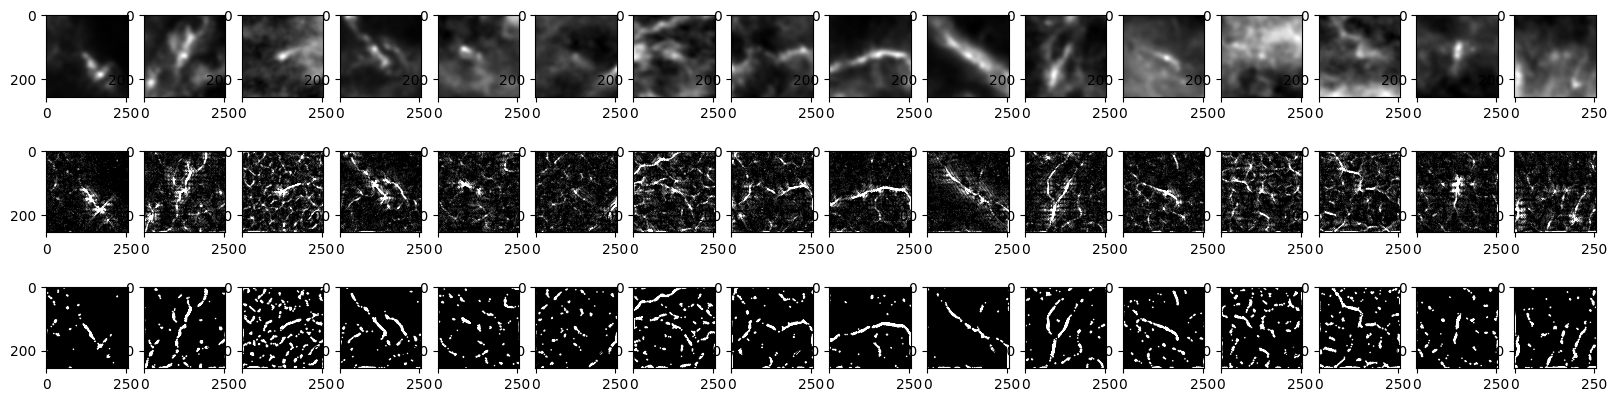

In [15]:
# PREPROCESSING

images_morph = np.zeros((16, 256, 256))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
for i in range(images_planck_np.shape[0]):
    images_morph[i, :, :] = cv2.morphologyEx(images_planck_np[i, 0, :, :], cv2.MORPH_TOPHAT, kernel)

images_morph = images_morph/np.max(images_morph) * 255
print(np.max(images_morph), np.average(images_morph))

images_morph_2 = np.zeros((16, 256, 256))
kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
for i in range(images_planck_np.shape[0]):
    images_morph_2[i, :, :] = cv2.dilate(cv2.morphologyEx(images_morph[i, :, :], cv2.MORPH_OPEN, kernel_2, iterations=1), kernel_2, iterations=1)
print(np.max(images_morph_2), np.average(images_morph_2), np.min(images_morph_2))

fig, axs = plt.subplots(3, batch_size, figsize=(size,size/4))
for i in range(batch_size):
    axs[0, i].imshow(images_planck[i,0,:,:], cmap='gray', vmin=0, vmax=1)  
    axs[1, i].imshow(images_morph[i,:,:], cmap='gray', vmin=0, vmax=10)
    axs[2, i].imshow(images_morph_2[i,:,:], cmap='gray', vmin=0, vmax=5)

tensor(0.2255) tensor(1.)


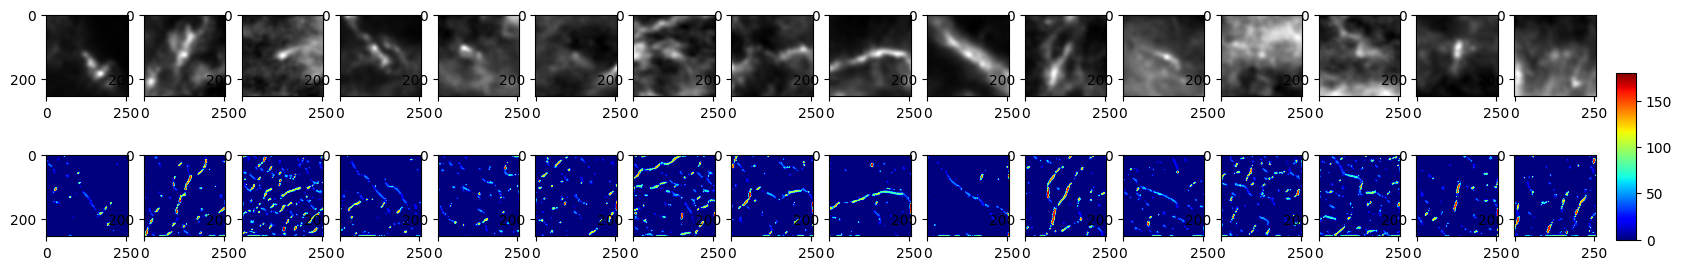

In [17]:
unet_masks = get_unet_masks(unet, torch.from_numpy(images_morph_2).to(torch.float32).unsqueeze(1))

print(torch.mean(images_planck), torch.max(images_planck))

fig, axs = plt.subplots(2, batch_size, figsize=(size,size/6))
for i in range(batch_size):
    axs[0, i].imshow(images_planck[i,0,:,:], cmap='gray', vmin=0, vmax=1)
    im = axs[1, i].imshow(unet_masks[i,:,:].to(torch.float32), cmap='jet', vmin=0, vmax=180)  
cbax = fig.add_axes([0.91, 0.1529, 0.01, 0.5])
fig.colorbar(im, cax=cbax)
plt.show()